In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [2]:
dataset = read_csv('ordered_atoms.csv', index_col=0, low_memory=False)

print(dataset.head(5))

   time  atom        Px        Py       Pz        Fx        Fy        Fz  \
0     0     1   0.27497   0.22765  0.40548  1.185458 -1.527830 -4.614324   
1     0     2   2.13410   1.61428  1.62211 -4.601109 -0.659241  1.090967   
2     0     3  12.05408  12.60878  2.90295  4.530882 -2.598597  2.008448   
3     0     4   0.85376   1.93829  4.87515  3.975239  0.917088 -2.261618   
4     0     5  12.70257   0.12956  6.09076 -1.861295 -0.908830  5.337542   

       t_Px      t_Py     t_Pz      t_Fx      t_Fy      t_Fz  
0   0.27747   0.22691  0.40192  1.173813 -1.541970 -4.631340  
1   2.13367   1.62206  1.61886 -4.672077 -0.805457  1.064703  
2  12.05656  12.60888  2.89414  4.432026 -2.609304  2.213726  
3   0.85851   1.94084  4.87902  3.846336  0.828634 -2.289510  
4  12.70216   0.12829  6.09563 -1.790789 -0.845025  5.255177  


In [3]:
df2 = dataset[['atom','Px','Py','Pz','Fx','Fy','Fz',  't_Px', 't_Py','t_Pz','t_Fx','t_Fy','t_Fz']]
df2.index.name =  'index'

In [4]:
print(df2.head(5))

       atom        Px        Py       Pz        Fx        Fy        Fz  \
index                                                                    
0         1   0.27497   0.22765  0.40548  1.185458 -1.527830 -4.614324   
1         2   2.13410   1.61428  1.62211 -4.601109 -0.659241  1.090967   
2         3  12.05408  12.60878  2.90295  4.530882 -2.598597  2.008448   
3         4   0.85376   1.93829  4.87515  3.975239  0.917088 -2.261618   
4         5  12.70257   0.12956  6.09076 -1.861295 -0.908830  5.337542   

           t_Px      t_Py     t_Pz      t_Fx      t_Fy      t_Fz  
index                                                             
0       0.27747   0.22691  0.40192  1.173813 -1.541970 -4.631340  
1       2.13367   1.62206  1.61886 -4.672077 -0.805457  1.064703  
2      12.05656  12.60888  2.89414  4.432026 -2.609304  2.213726  
3       0.85851   1.94084  4.87902  3.846336  0.828634 -2.289510  
4      12.70216   0.12829  6.09563 -1.790789 -0.845025  5.255177  


In [5]:
#df2 = df2[df2['atom']==1]
df2.drop('atom', axis=1, inplace=True)
print(df2.head(10))

             Px        Py        Pz        Fx        Fy        Fz      t_Px  \
index                                                                         
0       0.27497   0.22765   0.40548  1.185458 -1.527830 -4.614324   0.27747   
1       2.13410   1.61428   1.62211 -4.601109 -0.659241  1.090967   2.13367   
2      12.05408  12.60878   2.90295  4.530882 -2.598597  2.008448  12.05656   
3       0.85376   1.93829   4.87515  3.975239  0.917088 -2.261618   0.85851   
4      12.70257   0.12956   6.09076 -1.861295 -0.908830  5.337542  12.70216   
5       1.06394   1.39588   8.05172  2.984083  3.021378 -2.083314   1.06904   
6       0.15928  12.57988   9.41603 -2.773368  1.320404  0.073289   0.15627   
7       1.92214   1.82439  11.30727 -2.901205 -0.454694  0.240227   1.92966   
8       0.21907   3.17640  12.75646 -0.610102  0.700844 -0.335467   0.21989   
9       1.34256   5.15166   1.90630  6.847360 -3.161887 -5.186860   1.34107   

           t_Py      t_Pz      t_Fx      t_Fy      

/usr/local/anaconda/envs/env_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# load dataset
#dataset = read_csv('berny.csv', header=0, index_col=0)
values = df2.values
# specify columns to plot
groups = [0,1, 2, 3, 4, 5]

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i*128))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i*128))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = y_true, y_pred
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
values = df2[['Px','Py','Pz','Fx','Fy','Fz']].values
#values = df2.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')


In [10]:
print (values.shape)

(256000, 6)


In [11]:
print(values)

[[  2.74969995e-01   2.27650002e-01   4.05479997e-01   1.18545794e+00
    6.75940000e+04  -4.61432409e+00]
 [  2.13409996e+00   1.61427999e+00   1.62211001e+00  -4.60110903e+00
    9.85720000e+04   1.09096706e+00]
 [  1.20540800e+01   1.26087799e+01   2.90295005e+00   4.53088188e+00
    3.87740000e+04   2.00844789e+00]
 ..., 
 [  6.03299999e+00   1.28129196e+01   6.05135012e+00   2.30774212e+00
    2.46404000e+05   5.40464211e+00]
 [  9.50306034e+00   1.04410200e+01   9.99911976e+00   1.39556396e+00
    7.75020000e+04  -7.79073000e-01]
 [  1.20128298e+01   1.11894798e+01   1.19057703e+01  -7.30089009e-01
    5.36870000e+04  -5.60950004e-02]]


In [12]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
#reframed = scaled 
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
#print(reframed.head())


In [13]:
print(reframed.shape)

(255872, 12)


In [14]:
print(reframed.head(5))

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
128   0.021288   0.017622   0.031392   0.572639   0.267814   0.310560   
129   0.165221   0.124973   0.125581   0.351305   0.390551   0.511727   
130   0.933223   0.976151   0.224741   0.700600   0.153626   0.544077   
131   0.066098   0.150057   0.377426   0.679346   0.649624   0.393516   
132   0.983429   0.010028   0.471536   0.456102   0.352729   0.661460   

      var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
128  0.021482  0.017565  0.031116  0.572193  0.266114  0.309960  
129  0.165188  0.125575  0.125329  0.348591  0.368542  0.510801  
130  0.933415  0.976159  0.224059  0.696818  0.152766  0.551315  
131  0.066466  0.150255  0.377725  0.674416  0.635210  0.392532  
132  0.983397  0.009930  0.471913  0.458799  0.362757  0.658556  


In [15]:
# split into train and test sets
values = reframed.values
train_size = int(len(df2) * 0.80)
train = values[:train_size, :]
test = values[train_size:, :]
# split into input and outputs
train_X, train_Y = train[:, :-6], train[:, -6:]
test_X, test_Y = test[:, :-6], test[:, -6:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_size)
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)


204800
(204800, 1, 6) (204800, 6) (51072, 1, 6) (51072, 6)


Train on 204800 samples, validate on 51072 samples
Epoch 1/100
6s - loss: 0.0476 - val_loss: 0.0068
Epoch 2/100
7s - loss: 0.0110 - val_loss: 0.0035
Epoch 3/100
6s - loss: 0.0069 - val_loss: 0.0020
Epoch 4/100
6s - loss: 0.0053 - val_loss: 0.0015
Epoch 5/100
6s - loss: 0.0047 - val_loss: 0.0013
Epoch 6/100
6s - loss: 0.0043 - val_loss: 0.0011
Epoch 7/100
6s - loss: 0.0040 - val_loss: 0.0010
Epoch 8/100
6s - loss: 0.0038 - val_loss: 9.1583e-04
Epoch 9/100
6s - loss: 0.0037 - val_loss: 8.2876e-04
Epoch 10/100
6s - loss: 0.0036 - val_loss: 7.6195e-04
Epoch 11/100
6s - loss: 0.0035 - val_loss: 6.6659e-04
Epoch 12/100
6s - loss: 0.0035 - val_loss: 6.4373e-04
Epoch 13/100
6s - loss: 0.0034 - val_loss: 6.3523e-04
Epoch 14/100
6s - loss: 0.0034 - val_loss: 6.4128e-04
Epoch 15/100
6s - loss: 0.0034 - val_loss: 5.9101e-04
Epoch 16/100
6s - loss: 0.0034 - val_loss: 5.8215e-04
Epoch 17/100
6s - loss: 0.0033 - val_loss: 5.4938e-04
Epoch 18/100
6s - loss: 0.0033 - val_loss: 5.6731e-04
Epoch 19/100
6

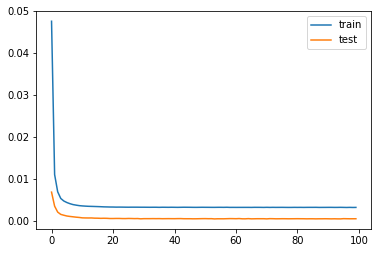

In [69]:
# design network
model = Sequential()
model.add(LSTM(50,activation='sigmoid', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(6,activation='linear'))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_Y, epochs=100, batch_size=128, validation_data=(test_X, test_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [70]:
# make a prediction
yhat = model.predict(test_X)



In [71]:
test_X2 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X2[:, 6:]), axis=1)



In [72]:
inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

In [73]:
# invert scaling for actual
test_Y2 = test_Y.reshape((len(test_Y), 6))
inv_y = concatenate((test_Y2, test_X2[:, 6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

In [74]:
# calculate Statiscal
avg_mse = 0
avg_rmse = 0
avg_mae = 0
for i in range (0,6):
    if i != 4 :
        mse = mean_squared_error(inv_y[:,i], inv_yhat[:,i])
        rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
        mae = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
        avg_mse = avg_mse + mse
        avg_rmse = avg_rmse + rmse
        avg_mae = avg_mae + mae
print('MSE: %.4f' % (avg_mse/5))
print('RMSE: %.4f' % (avg_rmse/5))
print('MAE: %.4f ' % (avg_mae/5))
r2 = r2_score(inv_y, inv_yhat)
print('R2_Score: %.4f ' % (r2))

MSE: 0.1273
RMSE: 0.3546
MAE: 0.2186 
R2_Score: 0.9885 


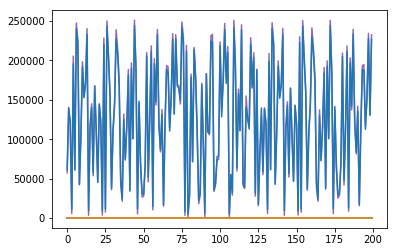

In [75]:
# plot baseline and predictions
plt.plot(inv_y[0:200])
plt.plot(inv_yhat[0:200])
plt.show()

In [76]:
print (inv_y.shape)
print(inv_yhat.shape)

(51072, 6)
(51072, 6)


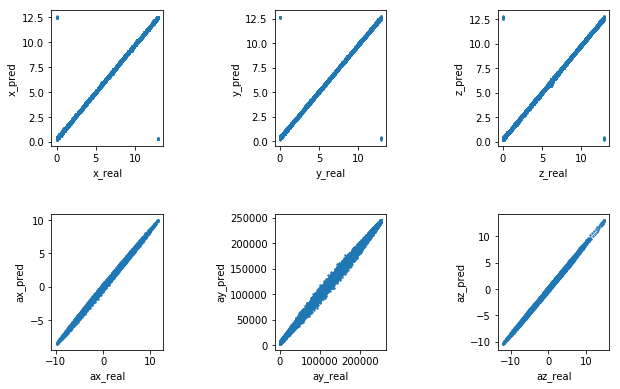

In [77]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(inv_y[:,0], inv_yhat[:,0], s= 2)
ax1.set_xlabel('x_real')
ax1.set_ylabel('x_pred')
ax2.scatter(inv_y[:,1], inv_yhat[:,1], s= 2)
ax2.set_xlabel('y_real')
ax2.set_ylabel('y_pred')
ax3.scatter(inv_y[:,2], inv_yhat[:,2], s= 2)
ax3.set_xlabel('z_real')
ax3.set_ylabel('z_pred')
ax4.scatter(inv_y[:,3], inv_yhat[:,3], s= 2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
ax5.scatter(inv_y[:,4], inv_yhat[:,4], s= 2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
ax6.scatter(inv_y[:,5], inv_yhat[:,5], s= 2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()